# Predict the wind speed

A summarised set of methods and results

In [2]:
import requests
from pathlib import Path
from tqdm import tqdm
import logging
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


d:\GitHub\wedowind-sye\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BYTES_MB = 1024 * 1024

In [4]:

def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [5]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [6]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_SCADA_2022_4457.zip?download=1"
outfile = Path("Kelmarsh_SCADA_2022_4457.zip")

if not outfile.is_file():
    download_file(url,outfile)

with zipfile.ZipFile(outfile,"r") as zip_ref:
    zip_ref.extractall()


In [7]:
scada_files = list(Path().rglob("Turbine_Data*.csv"))

In [8]:
use_columns = [
            "# Date and time",
            "Power (kW)",
            "Wind speed (m/s)",
            "Wind direction (°)",
            "Nacelle position (°)",
            "Blade angle (pitch position) A (°)",
        ]

csv_params = {
        "index_col": "# Date and time",
        "parse_dates": True,
        "skiprows": 9,
        "usecols": use_columns,
    }

In [9]:
str(scada_files[0])[-42:-32]

'Kelmarsh_1'

In [10]:
scada_lst = []

for file in scada_files:
    turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

    scada_wt = pd.read_csv(file, **csv_params)

    scada_wt["Turbine"] = turbine_name
    scada_wt.index.names = ["Timestamp"]
    scada_lst.append(scada_wt.copy())

scada = pd.concat(scada_lst)

In [11]:
scada

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Turbine
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.0000,Kelmarsh_1
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.0000,Kelmarsh_1
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.0470,Kelmarsh_1
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.0065,Kelmarsh_1
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.0060,Kelmarsh_1
...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,210.193670,205.457916,1447.101428,0.1090,Kelmarsh_6
2022-12-31 23:20:00,9.149686,208.465164,205.457916,1572.766687,0.3910,Kelmarsh_6
2022-12-31 23:30:00,9.571797,213.539677,205.457916,1653.457245,1.1805,Kelmarsh_6


In [12]:
scada["Yaw error"] = (scada["Nacelle position (°)"] - scada["Wind direction (°)"]+180)%360-180 # TODO - circular difference rather than absolute

<Axes: xlabel='Timestamp'>

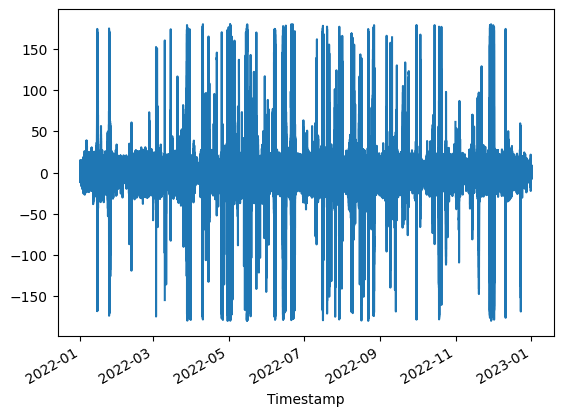

In [13]:
scada["Yaw error"].plot()

In [ ]:
target_turbine = "Kelmarsh_1"

In [15]:
scada_clean = scada[(scada["Turbine"]!=target_turbine) | ((scada["Turbine"]==target_turbine) & (scada["Blade angle (pitch position) A (°)"]<1.5) 
                            & (scada["Blade angle (pitch position) A (°)"]>-1.5))]

scada_clean = scada.copy()


In [16]:
scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")

C:\Users\Charlie\AppData\Local\Temp\ipykernel_16144\4243526468.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")


In [17]:
scada_clean

,Turbine,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,,
2022-01-01 00:00:00,Kelmarsh_1,6.781222,185.795348,193.731354,630.889598,0.0000,7.936005
2022-01-01 00:00:00,Kelmarsh_2,6.649725,185.131387,193.410889,630.786577,0.0000,8.279502
2022-01-01 00:00:00,Kelmarsh_3,6.526749,191.038261,191.092590,593.362961,0.0000,0.054329
2022-01-01 00:00:00,Kelmarsh_4,6.736784,185.012514,191.375766,613.850131,0.0000,6.363253
2022-01-01 00:00:00,Kelmarsh_5,5.357348,179.017514,194.111094,306.639859,0.0000,15.093580
...,...,...,...,...,...,...,...
2022-12-31 23:50:00,Kelmarsh_2,10.462493,208.765861,213.166046,1849.897888,2.0080,4.400185
2022-12-31 23:50:00,Kelmarsh_3,8.545551,211.568216,213.043030,1457.414063,0.6200,1.474814
2022-12-31 23:50:00,Kelmarsh_4,9.887900,207.402546,209.195862,1743.388065,1.5725,1.793316


In [18]:
scada_target = scada_clean[scada_clean["Turbine"]==target_turbine]

In [19]:
scada_others = scada_clean[scada_clean["Turbine"]!=target_turbine]

In [20]:
X = scada_others.pivot(columns='Turbine')
y = scada_target

In [21]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# AutoML

In [88]:
X_train.drop(columns=X_train.columns[-5:])

,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_5,Windspeedms_Kelmarsh_6,Winddirection_Kelmarsh_2,Winddirection_Kelmarsh_3,Winddirection_Kelmarsh_4,Winddirection_Kelmarsh_5,Winddirection_Kelmarsh_6,...,PowerkW_Kelmarsh_2,PowerkW_Kelmarsh_3,PowerkW_Kelmarsh_4,PowerkW_Kelmarsh_5,PowerkW_Kelmarsh_6,BladeanglepitchpositionA_Kelmarsh_2,BladeanglepitchpositionA_Kelmarsh_3,BladeanglepitchpositionA_Kelmarsh_4,BladeanglepitchpositionA_Kelmarsh_5,BladeanglepitchpositionA_Kelmarsh_6
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-06 05:10:00,9.710199,7.578574,9.898052,7.583085,6.055280,234.885229,238.855849,233.853607,233.968338,243.811837,...,1496.302301,953.261731,1598.596674,1036.115222,583.160730,0.616000,0.026500,1.64150,0.057500,0.000000
2022-02-01 06:00:00,9.860314,9.043675,8.806744,7.877486,7.245934,275.926019,275.827526,273.465941,270.216702,278.163514,...,1781.546387,1646.418884,1524.189011,1225.326994,726.852480,1.581500,0.823500,0.85450,0.305500,0.000000
2022-10-03 09:30:00,4.126135,3.667289,4.035159,3.751432,2.190902,176.690639,183.181480,170.805838,168.550160,188.497946,...,163.550511,97.942409,106.917497,88.699954,1.277278,0.000000,0.717000,0.24650,0.393500,1.490000
2022-09-25 04:00:00,5.854248,4.900426,4.148930,4.726335,3.594598,357.649629,358.020559,349.714523,352.910797,346.564836,...,387.172534,262.867732,115.476464,210.540405,86.172454,0.000000,0.000000,0.17150,0.000000,0.884737
2022-01-21 10:20:00,7.662050,7.433768,7.357551,6.114197,5.898984,275.863965,274.928575,270.545815,270.315755,277.036080,...,1077.790598,833.809445,913.927493,587.684012,406.331691,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21 13:10:00,2.265966,2.392039,2.527450,2.351263,2.974007,148.028327,156.974317,141.283349,148.012158,146.087333,...,5.129519,-4.878436,1.432689,-3.323797,-1.516263,3.908000,9.922105,14.95579,18.890001,91.930000
2022-11-14 09:20:00,2.851430,2.513470,4.457142,2.985729,3.434306,206.235814,200.064952,190.891510,206.876694,196.217111,...,15.992236,-6.234098,128.177754,20.727651,27.178581,1.411053,29.765001,0.12250,1.398000,15.943685
2022-09-28 17:20:00,6.479730,6.100201,3.986916,4.847975,4.798896,295.032253,299.808055,294.715499,286.581997,297.579877,...,577.446042,489.950267,172.847875,234.223954,247.910667,0.000000,0.000000,0.00000,0.000000,0.092500


In [90]:
y_train[["Power (kW)","Yaw error"]]

,Power (kW),Yaw error
Timestamp,,
2022-10-06 05:10:00,1405.848633,5.007870
2022-02-01 06:00:00,1474.256152,2.278361
2022-10-03 09:30:00,110.893872,3.016094
2022-09-25 04:00:00,267.141904,-5.115295
2022-01-21 10:20:00,882.995883,6.206038
...,...,...
2022-03-21 13:10:00,-1.520475,0.841725
2022-11-14 09:20:00,-2.227368,-3.060154
2022-09-28 17:20:00,572.747226,6.741195


In [ ]:
target_feature = "Power (kW)"

# Training with AutoGluon
predictor = TabularPredictor(
    label=target_feature, 
    eval_metric='mae'
)
predictor.fit(
    train_data=pd.concat([X_train.drop(columns=X_train.columns[-5:]),y_train[["Power (kW)","Yaw error"]]],axis=1), 
    time_limit=60*2, 
    presets='best_quality', 
    num_gpus='auto', 
    num_cpus='auto'
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250324_215916"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.34 GB / 15.94 GB (33.5%)
Disk Space Avail:   86.09 GB / 931.51 GB (9.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout va

In [113]:
target_prediction = predictor.predict(pd.concat([X_train.drop(columns=X_train.columns[-5:]),y_train["Yaw error"]],axis=1))

In [114]:
np.mean(abs(y[target_feature]-target_prediction))

17.07224398770451

In [115]:
test = pd.DataFrame(columns=(pd.concat([X_train.drop(columns=X_train.columns[-5:]),y_train["Yaw error"]],axis=1)).columns)

In [116]:
test["Yaw error"] = np.arange(-20,20,0.1)

In [117]:
col_fill_data = (pd.concat([X_train.drop(columns=X_train.columns[-5:]),y_train["Yaw error"]],axis=1)).median().drop("Yaw error")
for col in col_fill_data.index:
    test[col] = col_fill_data[col]

In [118]:
test


,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_5,Windspeedms_Kelmarsh_6,Winddirection_Kelmarsh_2,Winddirection_Kelmarsh_3,Winddirection_Kelmarsh_4,Winddirection_Kelmarsh_5,Winddirection_Kelmarsh_6,...,PowerkW_Kelmarsh_3,PowerkW_Kelmarsh_4,PowerkW_Kelmarsh_5,PowerkW_Kelmarsh_6,BladeanglepitchpositionA_Kelmarsh_2,BladeanglepitchpositionA_Kelmarsh_3,BladeanglepitchpositionA_Kelmarsh_4,BladeanglepitchpositionA_Kelmarsh_5,BladeanglepitchpositionA_Kelmarsh_6,Yaw error
0,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,-20.0
1,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,-19.9
2,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,-19.8
3,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,-19.7
4,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,-19.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,19.5
396,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,19.6
397,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,19.7
398,6.26279,5.711187,5.919261,5.580052,5.29406,215.63419,219.79169,213.596269,211.576022,215.407244,...,368.865116,305.54376,343.551872,270.706795,0.028,0.16,0.074,0.0425,0.30125,19.8


In [119]:
target_prediction = predictor.predict(test)

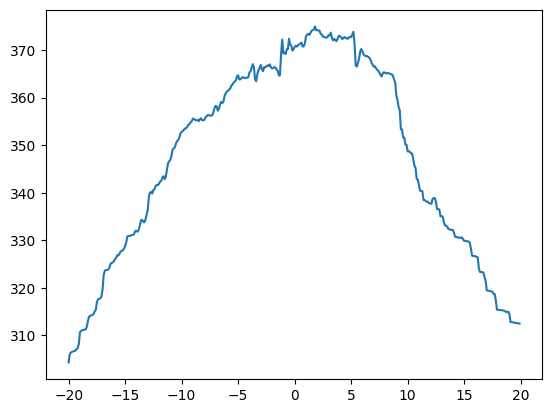

In [120]:
plt.plot(test["Yaw error"],target_prediction)